# **Deep Learning Assignment 2**

Team members:
- Despoina Aggelonidi f3352201
- Dimitrios Koutsianos f3352212
- Panagiota Tavoularea f3352217

In [ ]:
!nvidia-smi

Sun Jun 25 15:21:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   2957MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Installing and Importing Necessary Libraries**

In this section we import the libraries and install the optuna tuner which we will later use to find the best hyperparameters of our CNN. We also define a function, called `plot_history`, which constructs the curves that show the train/validation curves of a user-specified metric, per epoch.
We also create the `METRICS` list, which holds all the metrics that we will use on our models, as well as the `early_stopping` and `reduce_lr` criteria which will help us avoid overfitting on our models and escape local minima.


In [ ]:
%%capture
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import pickle
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

import optuna

from glob import glob
from PIL import Image, ImageOps
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D , LayerNormalization, BatchNormalization, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc, f1_score,precision_score, recall_score
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
%matplotlib inline

In [ ]:
#the function that creates the learning curves
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2, color = "#19E6E0")
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2, color = "#E6191F")
    x_ticks = np.arange(1, epochs + 1)
    #x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(f'{metric}')
    plt.legend()
    plt.show()

In [ ]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
]

In [ ]:
early_stopping = EarlyStopping(monitor='val_pr_auc',
                               patience=5,
                               restore_best_weights=True,
                               mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor = "val_pr_auc",
                              patience = 2,
                              cooldown = 2,
                              mode = 'max')

# **Splitting the Data** ⚠

<font color='red'>**Warning:**</font> The follownig process was run **locally** as a Google Colab runtime is not powerful enough to run the following blocks of code in a timely manner.

## **Importing necessary libraries for the splitting**

In [ ]:
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from tqdm import tqdm

import pandas as pd
import numpy as np
import os

## **Reading the train and valid csv files**

In [ ]:
train = pd.read_csv("MURA-v1.1/train_image_paths.csv", dtype = str,header=None)
train.columns = ['image_path']
train['Body_Part']  = train['image_path'].apply(lambda x: x.split('/')[2])
train['PatientId']  = train['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train['FolderId'] = train['image_path'].map(lambda x: x.split('/')[-2])
train['Study'] = train['FolderId'].map(lambda x: x.split('_')[0])
train['label'] = train['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')

In [ ]:
valid = pd.read_csv("MURA-v1.1/valid_image_paths.csv", header = None, dtype = str)
valid.columns = ['image_path']
valid['Body_Part']  = valid['image_path'].apply(lambda x: x.split('/')[2])
valid['PatientId']  = valid['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid['FolderId'] = valid['image_path'].map(lambda x: x.split('/')[-2])
valid['Study'] = valid['FolderId'].map(lambda x: x.split('_')[0])
valid['label'] = valid['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')

## **Splitting and saving the images on their respective folders**

In [ ]:
train, test = train_test_split(train, test_size=0.15, random_state=7)

In [ ]:
!mkdir Train_m
!mkdir Train_m/Negative
!mkdir Train_m/Positive
!mkdir Val_m
!mkdir Val_m/Positive
!mkdir Val_m/Negative
!mkdir Test_m
!mkdir Test_m/Positive
!mkdir Test_m/Negative

In [ ]:
train.reset_index(inplace = True)
for i in tqdm(range(len(train))):
    im = Image.open(train.image_path[i])
    name = "_".join(train.image_path[i].split("/"))

    if train.label[i] == 'positive':
        label = 'Positive'
    else:
        label = 'Negative'

    im.save(f'Train_m/{label}/{name}')


In [ ]:
valid.reset_index(inplace = True)
for i in tqdm(range(len(valid))):
    im = Image.open(valid.image_path[i])
    name = "_".join(valid.image_path[i].split("/"))

    if valid.label[i] == 'positive':
        label = 'Positive'
    else:
        label = 'Negative'

    im.save(f'Val_m/{label}/{name}')

In [ ]:
test.reset_index(inplace = True)
for i in tqdm(range(len(test))):
    im = Image.open(test.image_path[i])
    name = "_".join(test.image_path[i].split("/"))

    if test.label[i] == 'positive':
        label = 'Positive'
    else:
        label = 'Negative'

    im.save(f'Test_m/{label}/{name}')

After these blocks of code were run locally, the folders `Train_m`, `Val_m` and `Test_m` were zipped and uploaded on Google Drive as .zip files which we unzip directly on our runtime.

# **Importing Data From Drive**

As we have saved the images on our Google Drive accounts, we now have to import them on the runtime.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#unzipping the images from their respective folders
!unzip /content/drive/MyDrive/MURA_data/Train_m.zip
!unzip /content/drive/MyDrive/MURA_data/Val_m.zip
!unzip /content/drive/MyDrive/MURA_data/Test_m.zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: Test_m/Positive/MURA-v1.1_train_XR_FINGER_patient03165_study1_positive_image1.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_ELBOW_patient05428_study1_positive_image1.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_WRIST_patient06901_study1_positive_image2.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_WRIST_patient06824_study1_positive_image1.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_FOREARM_patient09220_study1_positive_image2.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_HAND_patient09806_study2_positive_image2.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_FINGER_patient03672_study1_positive_image3.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_WRIST_patient04750_study1_positive_image1.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_WRIST_patient06943_study1_positive_image1.png  
  inflating: Test_m/Positive/MURA-v1.1_train_XR_SHOULDER_patient01047_study1_p

# **Exploratory Data Analysis**

We will now create some dataframes to facilitate the creation of the plots that follow. By creating this plots we aim to get a better understanding of our data.

In [ ]:
os.chdir(r'/content/drive/MyDrive/MURA/MURA-v1.1/MURA-v1.1')
path = '../MURA-v1.1'

In [ ]:
train = pd.read_csv(os.path.join(path,"train_image_paths.csv"),dtype=str,header=None)
train.columns = ['image_path']

In [ ]:
train['Body_Part']  = train['image_path'].apply(lambda x: x.split('/')[2])
train['PatientId']  = train['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train['FolderId'] = train['image_path'].map(lambda x: x.split('/')[-2])
train['Study'] = train['FolderId'].map(lambda x: x.split('_')[0])
train['label'] = train['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
train.head()

,image_path,Body_Part,PatientId,FolderId,Study,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,study1,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,study1,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,00001,study1_positive,study1,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,00002,study1_positive,study1,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,00002,study1_positive,study1,positive


In [ ]:
valid = pd.read_csv(os.path.join(path,"valid_image_paths.csv"),dtype=str,header=None)
valid.columns = ['image_path']

In [ ]:
valid['Body_Part']  = valid['image_path'].apply(lambda x: x.split('/')[2])
valid['PatientId']  = valid['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid['FolderId'] = valid['image_path'].map(lambda x: x.split('/')[-2])
valid['Study'] = valid['FolderId'].map(lambda x: x.split('_')[0])
valid['label'] = valid['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid.head()

,image_path,Body_Part,PatientId,FolderId,Study,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,study1,positive
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,study1,positive
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,study1,positive
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,11185,study1_positive,study1,positive
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,11186,study1_positive,study1,positive


**Train Set:**\
As one can notice from the first plot, regarding the training set, the "negative" class includes more x-rays than the "positive" class. This signifies that our data is imbalanced. We should keep this in mind during evaluation as the Accuracy metric can be misleading.

From the second plot we observe that the body part with the most x-rays is the wrist followed by the shoulder.

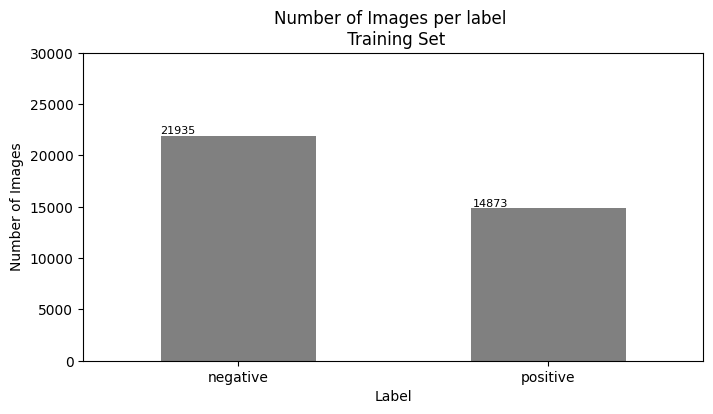

In [ ]:
ax=train['label'].value_counts().sort_index().plot(kind='bar',color=['gray'], figsize=(8,4))
plt.title('Number of Images per label \n Training Set')
plt.ylabel('Number of Images')
plt.xlabel('Label')
plt.ylim(top=30000)
plt.xticks(rotation=0)
#adding the bar labels
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010),size=8)
plt.show()

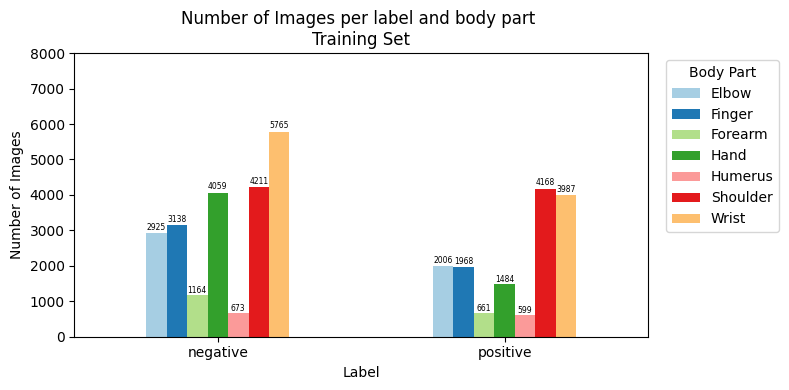

In [ ]:
grouped_data = train.groupby(['label', 'Body_Part']).size().unstack().fillna(0)
num_colors = 7
color_palette = sns.color_palette("Paired", num_colors)
ax = grouped_data.plot(kind='bar', stacked=False, figsize=(8, 4), color=color_palette)

plt.title('Number of Images per label and body part \nTraining Set')
plt.ylabel('Number of Images')
plt.xlabel('Label')
plt.ylim(top=8000)
plt.xticks(rotation=0)

# Adding the bar labels
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height() * 1.010), ha='center', va='bottom', size=5.5)

legend_labels = ['Elbow', 'Finger', 'Forearm','Hand','Humerus','Shoulder','Wrist']
plt.legend(legend_labels, title='Body Part', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Validation Set:**\
When it comes to the Validation set, we notice that we also face data imbalances but this time the difference is not notable.

By observing the second plot it is evident that the distribution of the x-rays among the body parts follows the same pattern as before.

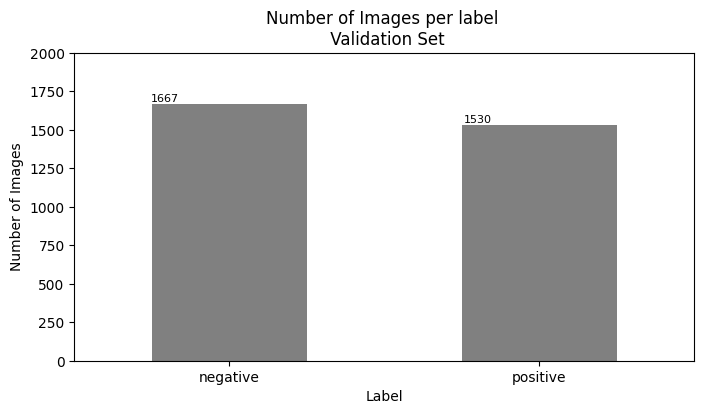

In [ ]:
ax=valid['label'].value_counts().sort_index().plot(kind='bar',color=['gray'], figsize=(8,4))
plt.title('Number of Images per label \n Validation Set')
plt.ylabel('Number of Images')
plt.xlabel('Label')
plt.ylim(top=2000)
plt.xticks(rotation=0)
#adding the bar labels
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010),size=8)
plt.show()

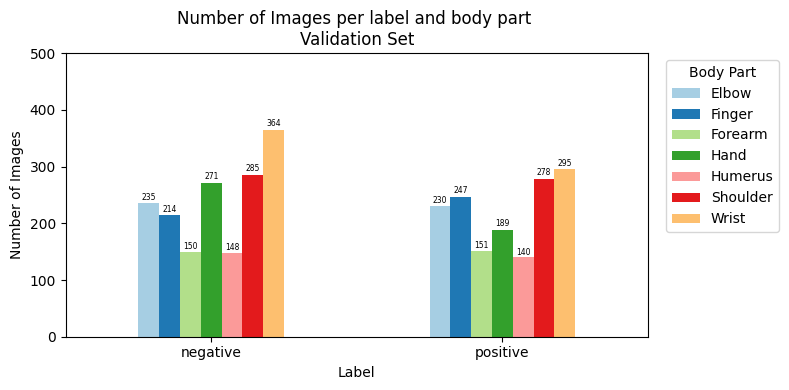

In [ ]:
grouped_data = valid.groupby(['label', 'Body_Part']).size().unstack().fillna(0)
num_colors = 7
color_palette = sns.color_palette("Paired", num_colors)
ax = grouped_data.plot(kind='bar', stacked=False, figsize=(8, 4), color=color_palette)

plt.title('Number of Images per label and body part \nValidation Set')
plt.ylabel('Number of Images')
plt.xlabel('Label')
plt.ylim(top=500)
plt.xticks(rotation=0)

# Adding the bar labels
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height() * 1.010), ha='center', va='bottom', size=5.5)

legend_labels = ['Elbow', 'Finger', 'Forearm','Hand','Humerus','Shoulder','Wrist']
plt.legend(legend_labels, title='Body Part', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

# **Creating Data Loaders**

The following snippets of code create TensorFlow datasets containing images from the specified directories, namely the Train, Val and Test ones, with their corresponding class labels inferred from the subdirectories. The images are resized to a uniform size (128 by 128) and shuffled. These datasets will be used for the train and evaluation processes of the models that will follow.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "Train_m",
    labels = "inferred",
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 31286 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Negative', 'Positive']


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = "Val_m",
    labels = "inferred",
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3197 files belonging to 2 classes.


In [ ]:
class_names_val = val_ds.class_names
print(class_names_val)

['Negative', 'Positive']


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  directory = "Test_m",
    labels = "inferred",
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5522 files belonging to 2 classes.


In [ ]:
class_names_test = test_ds.class_names
print(class_names_test)

['Negative', 'Positive']


The following segment of code normalizes the pixel values of the images in the datasets by dividing the pixel values by 255, which leads to the images' pixel intensities being scaled down to a range between 0 and 1.

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(val_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(test_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.065257356 0.9817709
0.0058823535 0.563917
0.0 1.0


The next code block will select randomly some images of the dataset and flip them, either horizontally or vertically. It will also select some images randomly and rotate them in a range of $-15^{\circ}$ and $15^{\circ}$.
These transformations will be applied on all three of our datasets.

In [ ]:
randomflip_layer = tf.keras.layers.RandomFlip("horizontal_and_vertical")
train_ds = train_ds.map(lambda x, y: (randomflip_layer(x), y))
randomrotation_layer = tf.keras.layers.RandomRotation(factor = (-1/12,1/12))
train_ds = train_ds.map(lambda x, y: (randomrotation_layer(x), y))

val_ds = val_ds.map(lambda x, y: (randomflip_layer(x), y))
val_ds = val_ds.map(lambda x, y: (randomrotation_layer(x), y))

test_ds = test_ds.map(lambda x, y: (randomflip_layer(x), y))
test_ds = test_ds.map(lambda x, y: (randomrotation_layer(x), y))

We now continue by printing some images of the first batch of both the train and test datasets to get an idea of how they look like after these transformations.

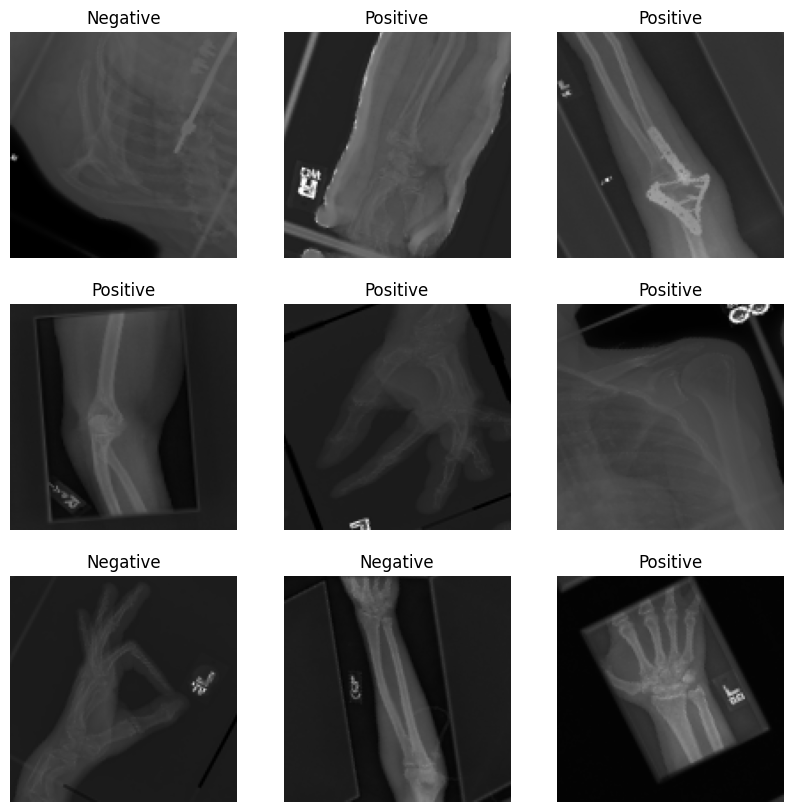

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

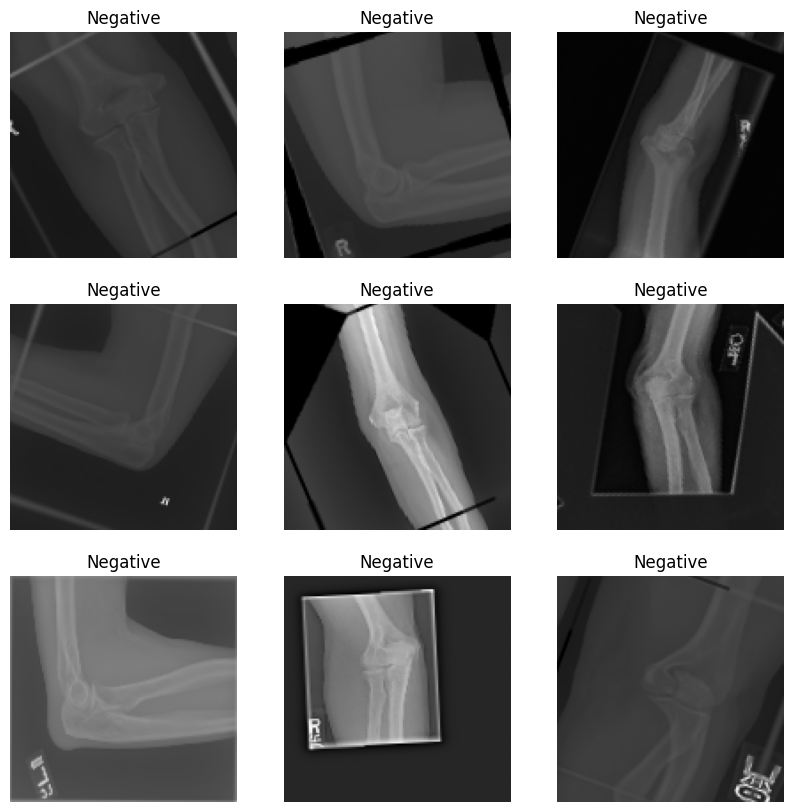

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

 <font color='red'> **ATTENTION: ONLY RUN THE FOLLOWING CELL FOR THE CUSTOM CNN, NOT THE PRE-TRAINED MODELS!!!!!**.</font>

To expedite the training process of the CNN model we are about to create, we will employ a technique called prefetching. This technique involves loading and storing all of the images in our dataset into the RAM in advance, instead of fetching each batch of images separately whenever it is required.

By gradually prefetching the entire dataset into RAM, we eliminate the potential bottleneck of reading and loading images from storage during training. This can significantly improve training speed as the model can access the images directly from the RAM, which is much faster compared to reading them from disk.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **CNN**
The first model we will employ on this classification task is the one that gave us the best results on the 1st Assignment (adjusted on this particular classification task), as it was capable enough to classify the garments of the fashion MNIST dataset. Let's see how it will perform on a more challenging task.

##**Objective Function**
Below, we define the objective function which creates and trains a CNN. This function will be later used by Optuna to perform hyperparameter tuning.


**Model Architecture:**

* The input layer takes images of shape (128, 128, 3).
* The first convolutional layer has 32 filters and a kernel size of (3, 3).
* The first max pooling layer reduces the spatial dimensions by a factor of 2.
* The second convolutional layer has 64 filters and a kernel size of (3, 3).
* The second max pooling layer further reduces the spatial dimensions.
* A layer normalization is applied to normalize the activations.
* A dropout layer randomly sets a fraction of inputs to 0, helping prevent overfitting.
* Two additional convolutional layers with 128 filters and a kernel size of (3, 3).
* Another max pooling layer reduces the spatial dimensions again.
* A second dropout layer is applied.
* A flattening layer that prepares the output from the previous max pooling layer for the fully connected layers.
* A dense layer
* Another dropout layer
* Another dense layer
* The output layer has a single unit with a sigmoid activation function, as it is a binary classification task.

We complie the model using the binary cross-entropy loss and Adam optimizer.

In [ ]:
def objective(trial):
  early_stopping = EarlyStopping(monitor='val_pr_auc',
                               patience=5,
                               restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor = "val_pr_auc",
                              patience = 2,
                              cooldown = 2)
  input = Input(
          shape=(128,128,3),
          name='Input'
    )
  x = input



  x = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=trial.suggest_categorical(f"activation_1", ["relu", "gelu", "swish", "tanh"]),
            kernel_initializer = trial.suggest_categorical(f"Kernel_initializer_1", ["glorot_uniform", "glorot_normal"]),
            name=f"Conv2D_1"
        )(x)
  x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name=f"MaxPool2D_1"
        )(x)
  x = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=trial.suggest_categorical(f"activation_2", ["relu", "gelu", "swish", "tanh"]),
            kernel_initializer = trial.suggest_categorical(f"Kernel_initializer_2", ["glorot_uniform", "glorot_normal"]),
            name=f"Conv2D_2"
        )(x)
  x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name=f"MaxPool2D_2"
        )(x)
  x = LayerNormalization(name = "Norm_Layer_1")(x)
  x = Dropout(
                rate=trial.suggest_categorical(f"Dropout_1", [0.1,0.15,0.2,0.25,0.3,0.4,0.5]),
                name = f"Dropout_1"
            )(x)
  x = Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=trial.suggest_categorical(f"activation_3", ["relu", "gelu", "swish", "tanh"]),
            kernel_initializer = trial.suggest_categorical(f"Kernel_initializer_3", ["glorot_uniform", "glorot_normal"]),
            name=f"Conv2D_1_3"
        )(x)
  x = Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=trial.suggest_categorical(f"activation_1_4", ["relu", "gelu", "swish", "tanh"]),
            kernel_initializer = trial.suggest_categorical(f"Kernel_initializer_4", ["glorot_uniform", "glorot_normal"]),
            name=f"Conv2D_4"
        )(x)
  x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name=f"MaxPool2D_3"
        )(x)
  x = Dropout(rate=trial.suggest_categorical(f"Dropout_2", [0.1,0.15,0.2,0.25,0.3,0.4,0.5]),
                name = f"Dropout_2"
            )(x)
  x = Flatten(name='Flatten')(x)

  x = Dense(units = trial.suggest_categorical("Dense_1", [32,64,128,256,512,1024,2048]),
            kernel_initializer = trial.suggest_categorical(f"Kernel_initializer_dense_1", ["glorot_uniform", "glorot_normal"]),
            activation=trial.suggest_categorical(f"activation_dense_1", ["relu", "gelu", "swish", "tanh"]),
            name = "Dense_1")(x)
  x = Dropout(rate=trial.suggest_categorical(f"Dropout_dense", [0.1,0.15,0.2,0.25,0.3,0.4,0.5]),
                name = f"Dropout_dense"
            )(x)
  x = Dense(units = trial.suggest_categorical("Dense_2", [32,64,128,256,512,1024,2048]),
            kernel_initializer = trial.suggest_categorical(f"Kernel_initializer_dense_2", ["glorot_uniform", "glorot_normal"]),
            activation=trial.suggest_categorical(f"activation_dense_2", ["relu", "gelu", "swish", "tanh"]),
            name = "Dense_2")(x)

  output = Dense(1, "sigmoid")(x)

  model = Model(inputs=input, outputs=output)

  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=METRICS)

  model.fit(train_ds,
              validation_data = val_ds,
              shuffle = True,
              batch_size = 512,
              epochs = 100,
              callbacks = [early_stopping, reduce_lr] )
  score = model.evaluate(val_ds)

  return score[6], score[7]

##**Hyperparameter Tuning**
Let us now proceed with the hyperparameter tuning. Our aim is to maximize the precision (score 6) and recall ( score 7) of the validation subsets.

In [ ]:
study = optuna.create_study(directions = ['maximize','maximize'])
study.optimize(objective, n_trials=5)

[I 2023-06-23 08:06:11,761] A new study created in memory with name: no-name-471a4336-52bc-4162-84d3-78cdf9b6a8c0


Epoch 1/100
978/978 [==============================] - 210s 198ms/step - loss: 0.8758 - tp: 43.0000 - fp: 84.0000 - tn: 18526.0000 - fn: 12633.0000 - binary_acc: 0.5935 - precision: 0.3386 - recall: 0.0034 - roc_auc: 0.5050 - pr_auc: 0.4079 - val_loss: 0.7152 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1667.0000 - val_fn: 1530.0000 - val_binary_acc: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.4786 - lr: 0.0835
Epoch 2/100
978/978 [==============================] - 49s 50ms/step - loss: 0.6770 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 18610.0000 - fn: 12676.0000 - binary_acc: 0.5948 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5032 - pr_auc: 0.4071 - val_loss: 0.7164 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1667.0000 - val_fn: 1530.0000 - val_binary_acc: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.4786 - lr: 0.0835
Epoch 3/100
978/978 [===============

[I 2023-06-23 08:13:46,632] Trial 0 finished with values: [0.0, 0.0] and parameters: {'activation_1': 'tanh', 'Kernel_initializer_1': 'glorot_normal', 'activation_2': 'relu', 'Kernel_initializer_2': 'glorot_uniform', 'Dropout_1': 0.2, 'activation_3': 'swish', 'Kernel_initializer_3': 'glorot_uniform', 'activation_1_4': 'relu', 'Kernel_initializer_4': 'glorot_normal', 'Dropout_2': 0.3, 'Dense_1': 2048, 'Kernel_initializer_dense_1': 'glorot_uniform', 'activation_dense_1': 'tanh', 'Dropout_dense': 0.4, 'Dense_2': 64, 'Kernel_initializer_dense_2': 'glorot_uniform', 'activation_dense_2': 'swish', 'lr': 0.08351474483406365}. 


Epoch 1/100
978/978 [==============================] - 51s 45ms/step - loss: 0.6779 - tp: 154.0000 - fp: 214.0000 - tn: 20063.0000 - fn: 14052.0000 - binary_acc: 0.5863 - precision: 0.4185 - recall: 0.0108 - roc_auc: 0.5021 - pr_auc: 0.4160 - val_loss: 0.6991 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1667.0000 - val_fn: 1530.0000 - val_binary_acc: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.4786 - lr: 8.2550e-04
Epoch 2/100
978/978 [==============================] - 42s 43ms/step - loss: 0.6753 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 18610.0000 - fn: 12676.0000 - binary_acc: 0.5948 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4991 - pr_auc: 0.4048 - val_loss: 0.6990 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1667.0000 - val_fn: 1530.0000 - val_binary_acc: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.4786 - lr: 8.2550e-04
Epoch 3/100
978/978 [=======

[I 2023-06-23 08:18:12,913] Trial 1 finished with values: [0.0, 0.0] and parameters: {'activation_1': 'relu', 'Kernel_initializer_1': 'glorot_uniform', 'activation_2': 'gelu', 'Kernel_initializer_2': 'glorot_normal', 'Dropout_1': 0.15, 'activation_3': 'gelu', 'Kernel_initializer_3': 'glorot_uniform', 'activation_1_4': 'gelu', 'Kernel_initializer_4': 'glorot_normal', 'Dropout_2': 0.5, 'Dense_1': 32, 'Kernel_initializer_dense_1': 'glorot_uniform', 'activation_dense_1': 'swish', 'Dropout_dense': 0.2, 'Dense_2': 128, 'Kernel_initializer_dense_2': 'glorot_normal', 'activation_dense_2': 'swish', 'lr': 0.0008254996066736244}. 


Epoch 1/100
978/978 [==============================] - 55s 51ms/step - loss: 0.6641 - tp: 914.0000 - fp: 904.0000 - tn: 19373.0000 - fn: 13292.0000 - binary_acc: 0.5883 - precision: 0.5028 - recall: 0.0643 - roc_auc: 0.5743 - pr_auc: 0.4644 - val_loss: 0.6834 - val_tp: 89.0000 - val_fp: 46.0000 - val_tn: 1621.0000 - val_fn: 1441.0000 - val_binary_acc: 0.5349 - val_precision: 0.6593 - val_recall: 0.0582 - val_roc_auc: 0.6152 - val_pr_auc: 0.5803 - lr: 1.0480e-04
Epoch 2/100
978/978 [==============================] - 49s 50ms/step - loss: 0.6491 - tp: 2743.0000 - fp: 2385.0000 - tn: 16225.0000 - fn: 9933.0000 - binary_acc: 0.6063 - precision: 0.5349 - recall: 0.2164 - roc_auc: 0.6254 - pr_auc: 0.5073 - val_loss: 0.6800 - val_tp: 213.0000 - val_fp: 127.0000 - val_tn: 1540.0000 - val_fn: 1317.0000 - val_binary_acc: 0.5483 - val_precision: 0.6265 - val_recall: 0.1392 - val_roc_auc: 0.6326 - val_pr_auc: 0.5929 - lr: 1.0480e-04
Epoch 3/100
978/978 [==============================] - 51s 52ms/s

[I 2023-06-23 08:38:56,788] Trial 2 finished with values: [0.6286286115646362, 0.4104575216770172] and parameters: {'activation_1': 'gelu', 'Kernel_initializer_1': 'glorot_normal', 'activation_2': 'swish', 'Kernel_initializer_2': 'glorot_normal', 'Dropout_1': 0.1, 'activation_3': 'gelu', 'Kernel_initializer_3': 'glorot_normal', 'activation_1_4': 'relu', 'Kernel_initializer_4': 'glorot_uniform', 'Dropout_2': 0.25, 'Dense_1': 64, 'Kernel_initializer_dense_1': 'glorot_uniform', 'activation_dense_1': 'gelu', 'Dropout_dense': 0.3, 'Dense_2': 64, 'Kernel_initializer_dense_2': 'glorot_normal', 'activation_dense_2': 'relu', 'lr': 0.00010479796915112774}. 


Epoch 1/100
978/978 [==============================] - 59s 56ms/step - loss: 1.0464 - tp: 5345.0000 - fp: 7198.0000 - tn: 13079.0000 - fn: 8861.0000 - binary_acc: 0.5343 - precision: 0.4261 - recall: 0.3762 - roc_auc: 0.5138 - pr_auc: 0.4199 - val_loss: 0.7064 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1667.0000 - val_fn: 1530.0000 - val_binary_acc: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.4786 - lr: 0.0223
Epoch 2/100
978/978 [==============================] - 54s 55ms/step - loss: 0.9118 - tp: 4751.0000 - fp: 6833.0000 - tn: 11777.0000 - fn: 7925.0000 - binary_acc: 0.5283 - precision: 0.4101 - recall: 0.3748 - roc_auc: 0.5055 - pr_auc: 0.4103 - val_loss: 0.7287 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1667.0000 - val_fn: 1530.0000 - val_binary_acc: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.4786 - lr: 0.0223
Epoch 3/100
978/978 [=========================

[I 2023-06-23 08:44:30,065] Trial 3 finished with values: [0.0, 0.0] and parameters: {'activation_1': 'gelu', 'Kernel_initializer_1': 'glorot_normal', 'activation_2': 'relu', 'Kernel_initializer_2': 'glorot_normal', 'Dropout_1': 0.5, 'activation_3': 'gelu', 'Kernel_initializer_3': 'glorot_uniform', 'activation_1_4': 'gelu', 'Kernel_initializer_4': 'glorot_normal', 'Dropout_2': 0.3, 'Dense_1': 1024, 'Kernel_initializer_dense_1': 'glorot_uniform', 'activation_dense_1': 'relu', 'Dropout_dense': 0.25, 'Dense_2': 1024, 'Kernel_initializer_dense_2': 'glorot_normal', 'activation_dense_2': 'tanh', 'lr': 0.022330106442950724}. 


Epoch 1/100
978/978 [==============================] - 61s 58ms/step - loss: 0.6700 - tp: 1328.0000 - fp: 1455.0000 - tn: 18822.0000 - fn: 12878.0000 - binary_acc: 0.5843 - precision: 0.4772 - recall: 0.0935 - roc_auc: 0.5559 - pr_auc: 0.4498 - val_loss: 0.6955 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1667.0000 - val_fn: 1530.0000 - val_binary_acc: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5619 - val_pr_auc: 0.5066 - lr: 1.4526e-05
Epoch 2/100
978/978 [==============================] - 55s 57ms/step - loss: 0.6624 - tp: 1201.0000 - fp: 1168.0000 - tn: 17442.0000 - fn: 11475.0000 - binary_acc: 0.5959 - precision: 0.5070 - recall: 0.0947 - roc_auc: 0.5874 - pr_auc: 0.4683 - val_loss: 0.6995 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1667.0000 - val_fn: 1530.0000 - val_binary_acc: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5546 - val_pr_auc: 0.5002 - lr: 1.4526e-05
Epoch 3/100
978/978 [===============

[I 2023-06-23 09:08:06,041] Trial 4 finished with values: [0.5931034684181213, 0.056209150701761246] and parameters: {'activation_1': 'swish', 'Kernel_initializer_1': 'glorot_normal', 'activation_2': 'relu', 'Kernel_initializer_2': 'glorot_uniform', 'Dropout_1': 0.5, 'activation_3': 'gelu', 'Kernel_initializer_3': 'glorot_uniform', 'activation_1_4': 'relu', 'Kernel_initializer_4': 'glorot_uniform', 'Dropout_2': 0.4, 'Dense_1': 2048, 'Kernel_initializer_dense_1': 'glorot_uniform', 'activation_dense_1': 'swish', 'Dropout_dense': 0.4, 'Dense_2': 64, 'Kernel_initializer_dense_2': 'glorot_normal', 'activation_dense_2': 'swish', 'lr': 1.4526469670535041e-05}. 


In [ ]:
study.best_trials[0].params

{'activation_1': 'gelu',
 'Kernel_initializer_1': 'glorot_normal',
 'activation_2': 'swish',
 'Kernel_initializer_2': 'glorot_normal',
 'Dropout_1': 0.1,
 'activation_3': 'gelu',
 'Kernel_initializer_3': 'glorot_normal',
 'activation_1_4': 'relu',
 'Kernel_initializer_4': 'glorot_uniform',
 'Dropout_2': 0.25,
 'Dense_1': 64,
 'Kernel_initializer_dense_1': 'glorot_uniform',
 'activation_dense_1': 'gelu',
 'Dropout_dense': 0.3,
 'Dense_2': 64,
 'Kernel_initializer_dense_2': 'glorot_normal',
 'activation_dense_2': 'relu',
 'lr': 0.00010479796915112774}

##**Model Training**
Next, we provide the hyperparameters that resulted from the tuning process to the model and proceed with the training.

In [ ]:
early_stopping = EarlyStopping(monitor='val_pr_auc',
                               patience=5,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor = "val_pr_auc",
                              patience = 2,
                              cooldown = 2)
input = Input(
          shape=(128,128,3),
          name='Input'
    )
x = input



x = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation="gelu",
            kernel_initializer = "glorot_normal",
            name=f"Conv2D_1"
        )(x)
x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name=f"MaxPool2D_1"
        )(x)
x = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation="swish",
            kernel_initializer = "glorot_normal",
            name=f"Conv2D_2"
        )(x)
x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name=f"MaxPool2D_2"
        )(x)
x = LayerNormalization(name = "Norm_Layer_1")(x)
x = Dropout(
                rate=0.1,
                name = f"Dropout_1"
            )(x)
x = Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation="gelu",
            kernel_initializer = "glorot_normal",
            name=f"Conv2D_1_3"
        )(x)
x = Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation="relu",
            kernel_initializer = "glorot_uniform",
            name=f"Conv2D_4"
        )(x)
x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name=f"MaxPool2D_3"
        )(x)
x = Dropout(rate=0.25,
                name = f"Dropout_2"
            )(x)
x = Flatten(name='Flatten')(x)

x = Dense(units = 64,
            kernel_initializer = "glorot_uniform",
            activation="gelu",
            name = "Dense_1")(x)
x = Dropout(rate=0.3,
                name = f"Dropout_dense"
            )(x)
x = Dense(units = 64,
            kernel_initializer = "glorot_normal",
            activation="relu",
            name = "Dense_2")(x)

output = Dense(1, "sigmoid")(x)

model = Model(inputs=input, outputs=output)

lr = 0.00010479796915112774

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=METRICS)

history = model.fit(train_ds,
              validation_data = val_ds,
              shuffle = True,
              batch_size = 512,
              epochs = 100,
              callbacks = [early_stopping, reduce_lr] )

Epoch 1/100
978/978 [==============================] - 219s 214ms/step - loss: 0.6628 - tp: 2988.0000 - fp: 1904.0000 - tn: 20031.0000 - fn: 11885.0000 - binary_acc: 0.6254 - precision: 0.6108 - recall: 0.2009 - roc_auc: 0.6447 - pr_auc: 0.5640 - val_loss: 0.6728 - val_tp: 507.0000 - val_fp: 346.0000 - val_tn: 1321.0000 - val_fn: 1023.0000 - val_binary_acc: 0.5718 - val_precision: 0.5944 - val_recall: 0.3314 - val_roc_auc: 0.6230 - val_pr_auc: 0.5875 - lr: 1.0480e-04
Epoch 2/100
978/978 [==============================] - 50s 51ms/step - loss: 0.6479 - tp: 3447.0000 - fp: 2853.0000 - tn: 15757.0000 - fn: 9229.0000 - binary_acc: 0.6138 - precision: 0.5471 - recall: 0.2719 - roc_auc: 0.6305 - pr_auc: 0.5186 - val_loss: 0.6671 - val_tp: 693.0000 - val_fp: 482.0000 - val_tn: 1185.0000 - val_fn: 837.0000 - val_binary_acc: 0.5874 - val_precision: 0.5898 - val_recall: 0.4529 - val_roc_auc: 0.6359 - val_pr_auc: 0.5960 - lr: 1.0480e-04
Epoch 3/100
978/978 [==============================] - 50s 5

##**Evaluation**

In [ ]:
eval = model.evaluate(test_ds)

173/173 [==============================] - 52s 298ms/step - loss: 0.6267 - tp: 914.0000 - fp: 666.0000 - tn: 2659.0000 - fn: 1283.0000 - binary_acc: 0.6470 - precision: 0.5785 - recall: 0.4160 - roc_auc: 0.6746 - pr_auc: 0.5673


In [ ]:
F1_CNN = 2 * (0.5785 * 0.4160 ) / (0.5785 + 0.4160 )
print("The F1-Score is:",round(F1_CNN,4))

The F1-Score is: 0.484


## **Learning Curves**
Below are presented the learning curves for the metrics of Precision, Recall, Binary Accuracy and Loss. This plots allow us to gain insights about the training process.

By looking at the Loss curves we can assume that there is no indication of overfitting since the distance between the two curves is around 0.1 which can be considered insignificant.

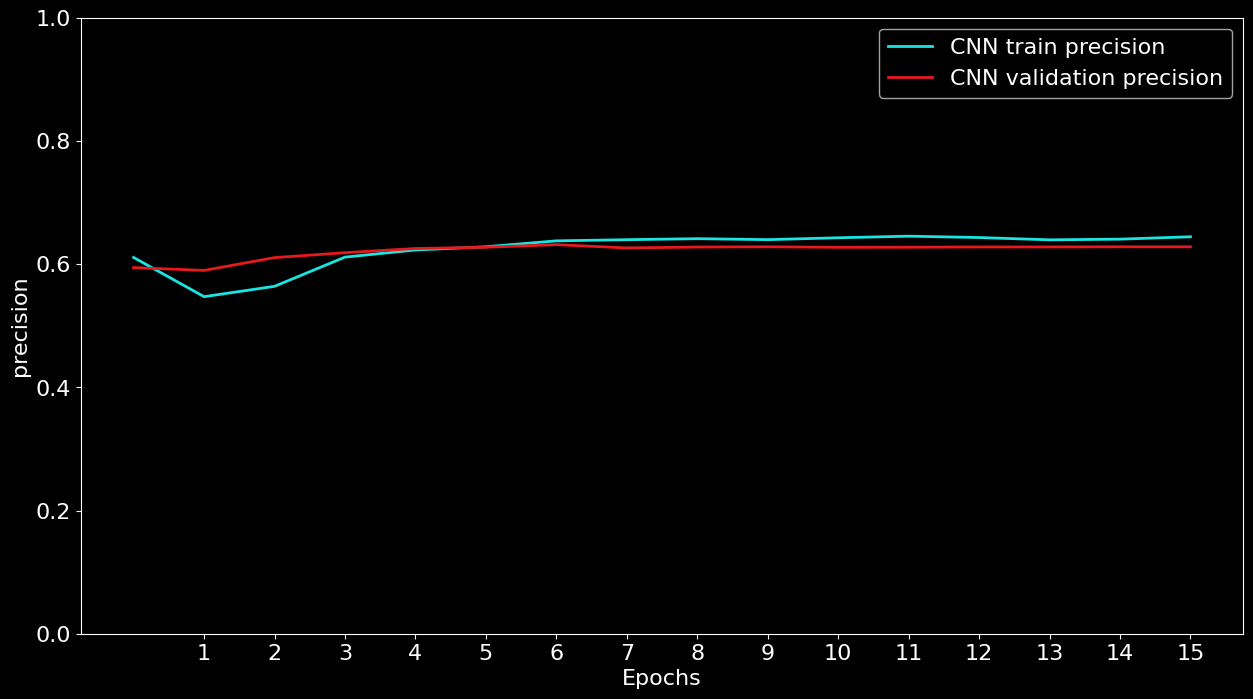

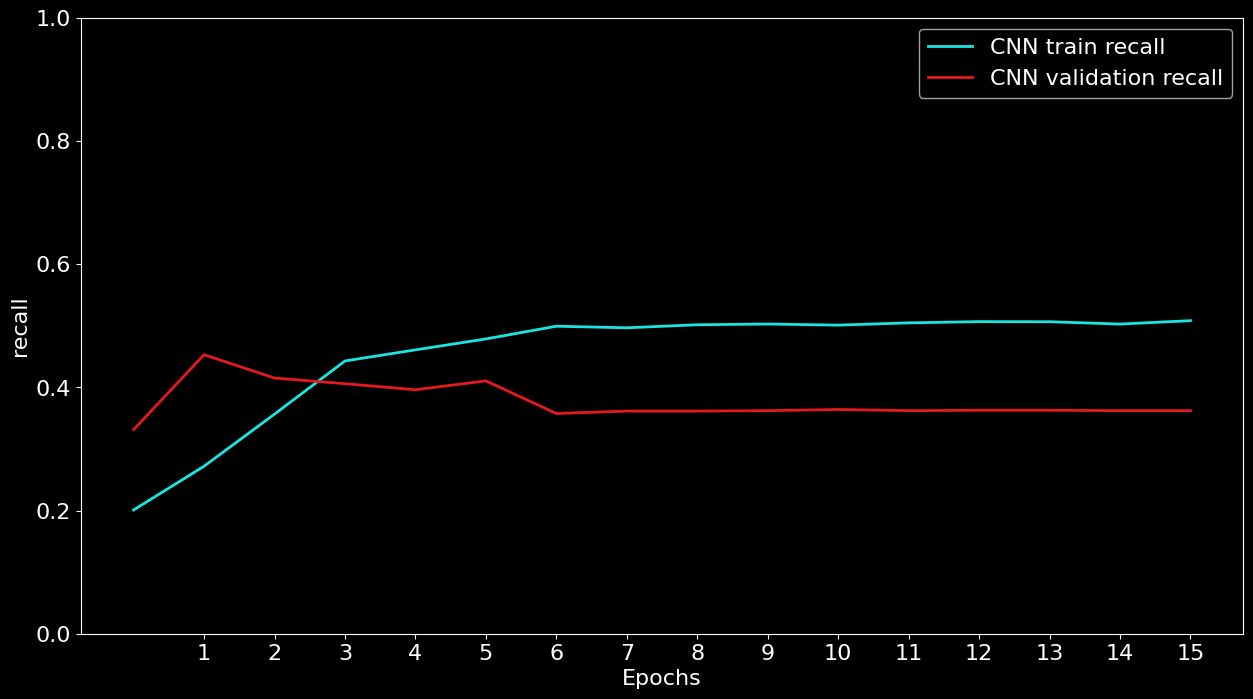

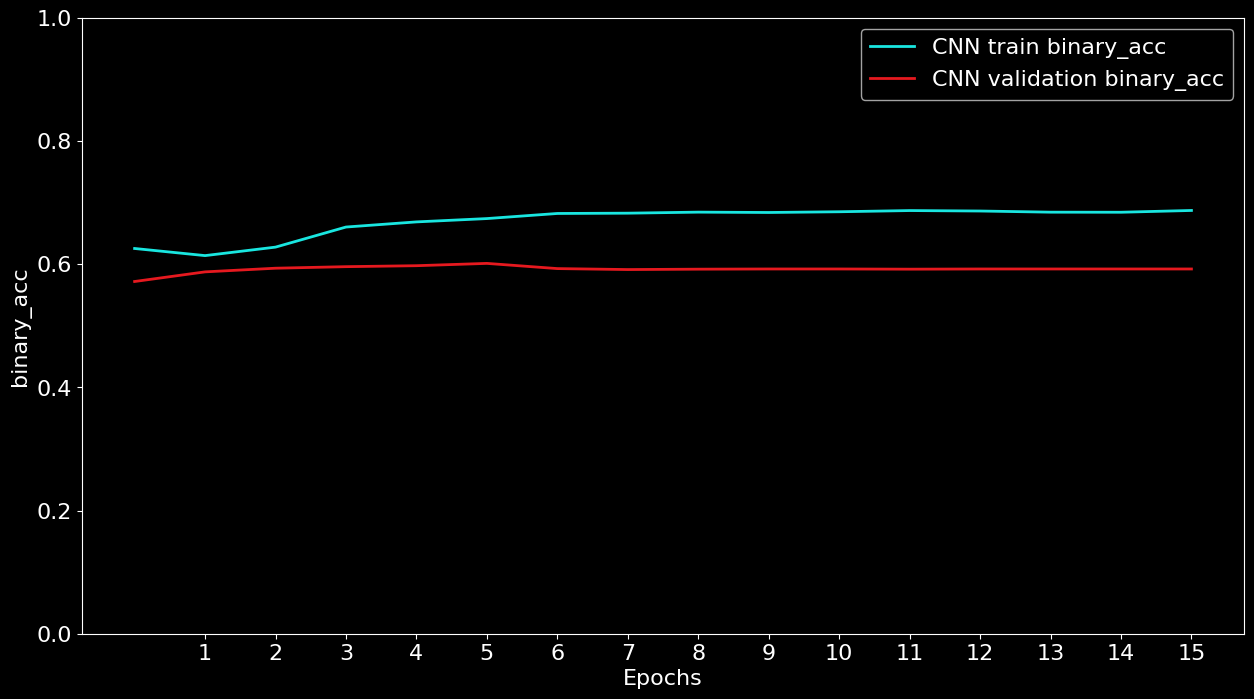

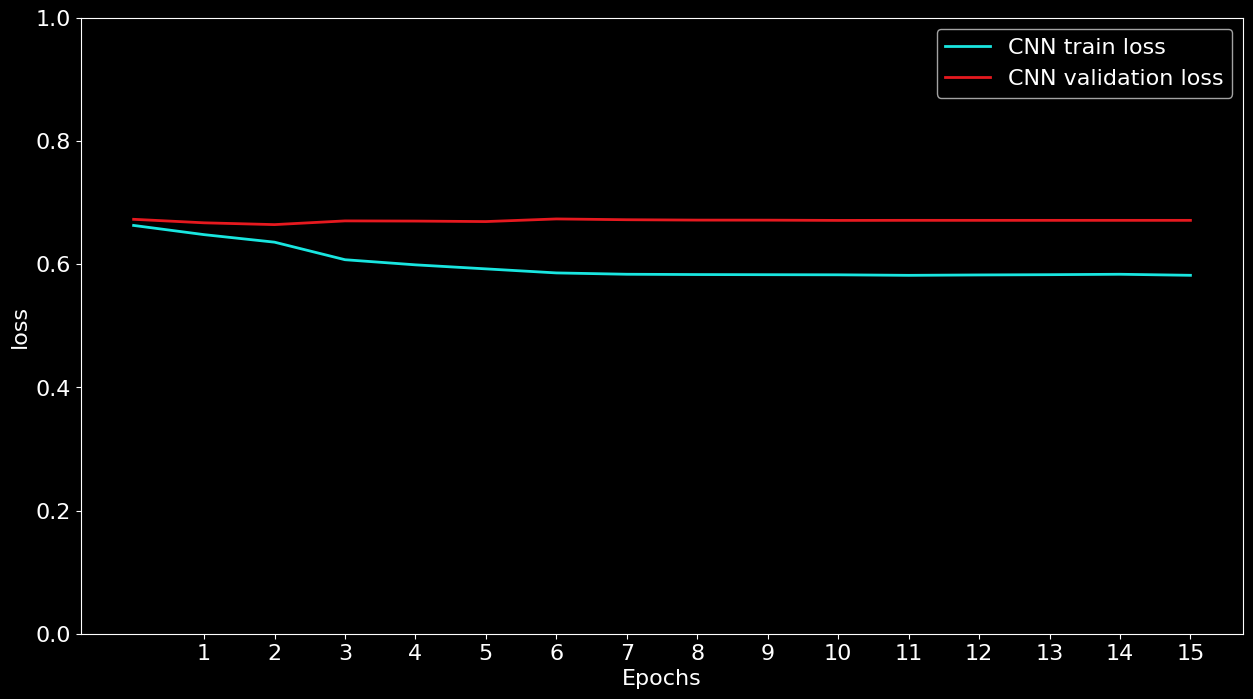

In [ ]:
plot_history(hs={'CNN': history}, epochs=15, metric='precision')
plot_history(hs={'CNN': history}, epochs=15, metric='recall')
plot_history(hs={'CNN': history}, epochs=15, metric='binary_acc')
plot_history(hs={'CNN': history}, epochs=15, metric='loss')

# **Densenet201**
As the CNN we previously used did not yield the results we expected we decided to fine-tune a pre-trained CNN, namely the [Densenet201](https://arxiv.org/abs/1608.06993) one which was used as a baseline by the creators of the Dataset.

##**Fine -Tuning**
The way we approached the fine-tuning process was:
1. we firstly added a number of dense layers on top of the pre-trained network
2. we froze the weights of the pre-trained network and trained the complete CNN for 15 epochs
3. we un-froze the weights of the layers of the pre-trained network and trained the complete model until the early_stopping criterion was used to terminate the training process.

In [ ]:
def train_model(
        upper_layers_optimizer,
        full_network_optimizer,
        upper_layers_epochs=15,
        full_network_epochs=85,
        batch_size=512,
        mlp_hidden_layers=[2048,512],
        mlp_hidden_activation='relu',
        mlp_dropout=0.2,
        output_activation='sigmoid',
        callbacks=None,
        verbose=0):

    np.random.seed(1402)
    set_seed(1981)

    base_model = tf.keras.applications.densenet.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3),
        pooling='max',
    )

    x = base_model.output
    # Define MLP layers.
    for i, units in enumerate(mlp_hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=mlp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if mlp_dropout > 0:
            x = Dropout(rate=mlp_dropout)(x)


    # Define the output layer.
    output = Dense(
        units=1,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=base_model.input, outputs=output)

    # First train the upper layers for a few epochs
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=upper_layers_optimizer, loss='binary_crossentropy', metrics=METRICS)
    hs_upper_layers = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=upper_layers_epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training upper layers.')
    print('------------------')

    # Now train the whole network with a low learning rate
    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer=full_network_optimizer, loss='binary_crossentropy', metrics=METRICS)

    hs_full_network = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=full_network_epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training full network.')
    print('------------------')

    model.summary() # Print a description of the model.
    return model, hs_upper_layers, hs_full_network


Let us now proceed with the training. Again, we are using early stopping to avoid overfitting and we gradually decrease the learning rate in order to avoid skipping the global minimum.  We opted to use [AdamW](https://arxiv.org/abs/1711.05101v3) as optimizer which is a stochastic optimization method that modifies the typical implementation of weight decay in Adam, by decoupling weight decay from the gradient update.

In [ ]:
upper_layers_optimizer = AdamW()
full_network_optimizer = AdamW(1e-5)
dns_model, dns_upper_hs, dns_full_network_hs = train_model(
    upper_layers_optimizer=upper_layers_optimizer,
    full_network_optimizer=full_network_optimizer,
    batch_size=512,
    mlp_hidden_layers=[2048, 2048, 1024, 512],
    mlp_hidden_activation='relu',
    mlp_dropout=0.2,
    output_activation='sigmoid',
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
978/978 [==============================] - 195s 184ms/step - loss: 0.6467 - tp: 4725.0000 - fp: 3151.0000 - tn: 15459.0000 - fn: 7951.0000 - binary_acc: 0.6451 - precision: 0.5999 - recall: 0.3728 - roc_auc: 0.6648 - pr_auc: 0.5735 - val_loss: 0.7153 - val_tp: 241.0000 - val_fp: 30.0000 - val_tn: 1637.0000 - val_fn: 1289.0000 - val_binary_acc: 0.5874 - val_precision: 0.8893 - val_recall: 0.1575 - val_roc_auc: 0.7233 - val_pr_auc: 0.7164 - lr: 0.0010
Epoch 2/15
978/978 [==============================] - 166s 169ms/step - loss: 0.6035 - tp: 5626.0000 - fp: 2856.0000 - tn: 15754.0000 - fn: 7050.0000 - binary_acc: 0.6834 - precision: 0.6633 - recall: 0.4438 - roc_auc: 0.7170 - pr_auc: 0.6400 - val_loss: 0.6913 - val_tp: 280.0000 - val_fp: 24.0000 - val_tn: 1643.0000 - val_fn: 1250.0000 - val_binary_acc: 0.6015 - val_precision: 0.9211 - val_recall: 0.1830 - val_roc_auc: 0.7284 - val_pr_auc: 0.7277 - lr: 0.0010
Epoch 3/15
978/978 [==============================] - 173s 177ms/step 

##**Saving & Loading**
With the training of the full network now complete we decided to save the configuration and the weights of the model on our Google Drive as the training process requires a lot of time and a lot of things can go wrong. (saved on Dimitris' Drive)

In [ ]:
model_json = dns_model.to_json()
with open("/content/drive/MyDrive/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize weights to HDF5
dns_model.save_weights("/content/drive/MyDrive/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/drive/MyDrive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer=AdamW(1e-5), loss='binary_crossentropy', metrics=METRICS)

##**Evaluation**

In [ ]:
eval = loaded_model.evaluate(test_ds)

173/173 [==============================] - 27s 150ms/step - loss: 0.4402 - tp: 1495.0000 - fp: 386.0000 - tn: 2939.0000 - fn: 702.0000 - binary_acc: 0.8030 - precision: 0.7948 - recall: 0.6805 - roc_auc: 0.8624 - pr_auc: 0.8362


In [ ]:
F1_DNet = 2 * (0.7948 *0.6805) / (0.7948 +0.6805)
print("The F1-Score is:",round(F1_DNet,4))

The F1-Score is: 0.7332


##**Learning Curves**

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1,4)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(f"{metric}")
    plt.legend()
    plt.show()

Below are given the learning curves. As the Training and Validation Curves both for the Upper Layers and the Full Network are not very far from each other we can assume that the model does not overifit.


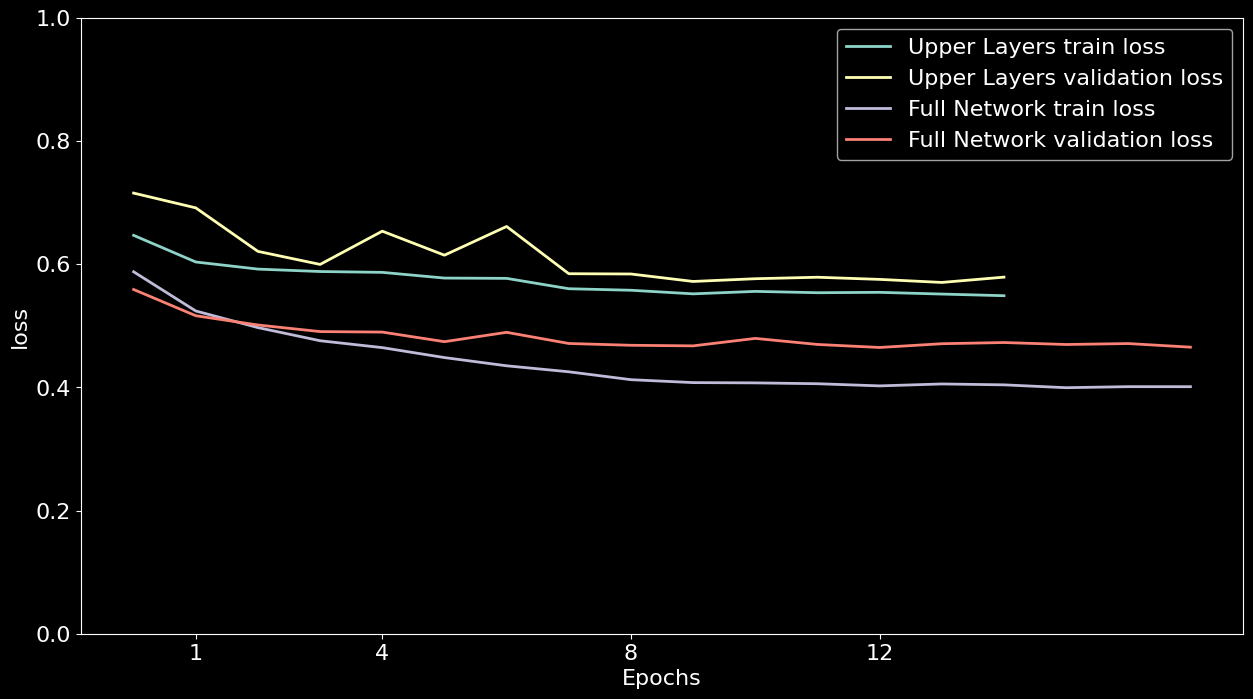

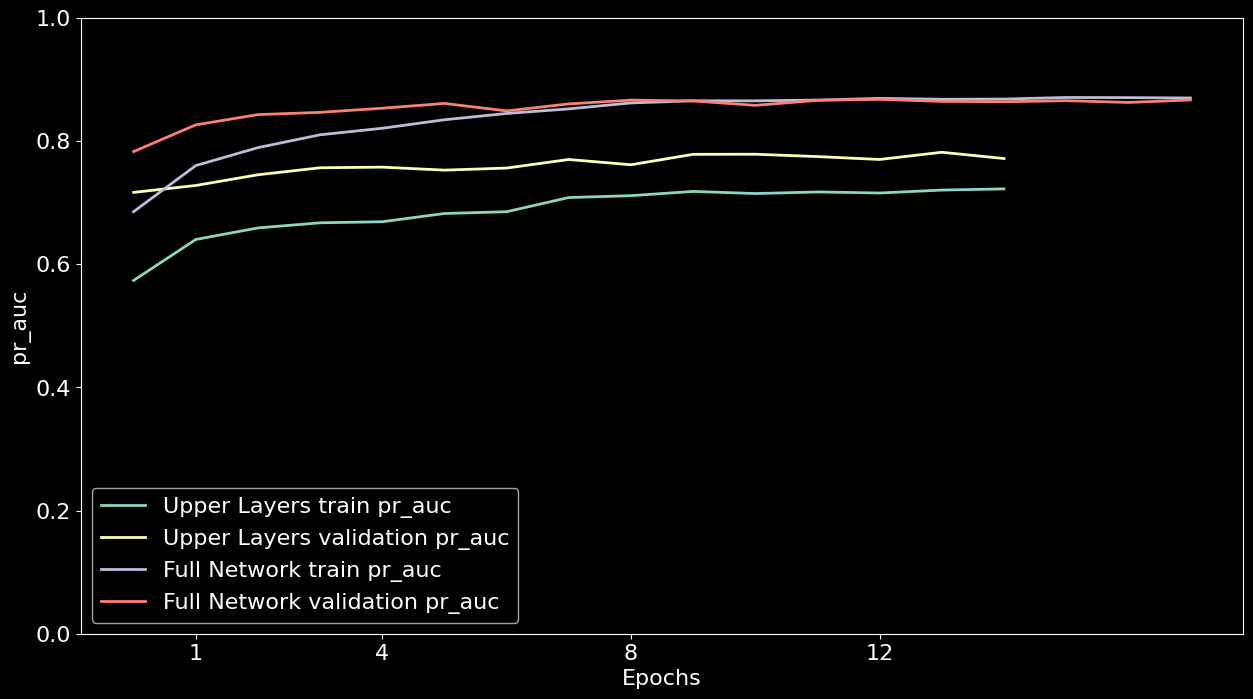

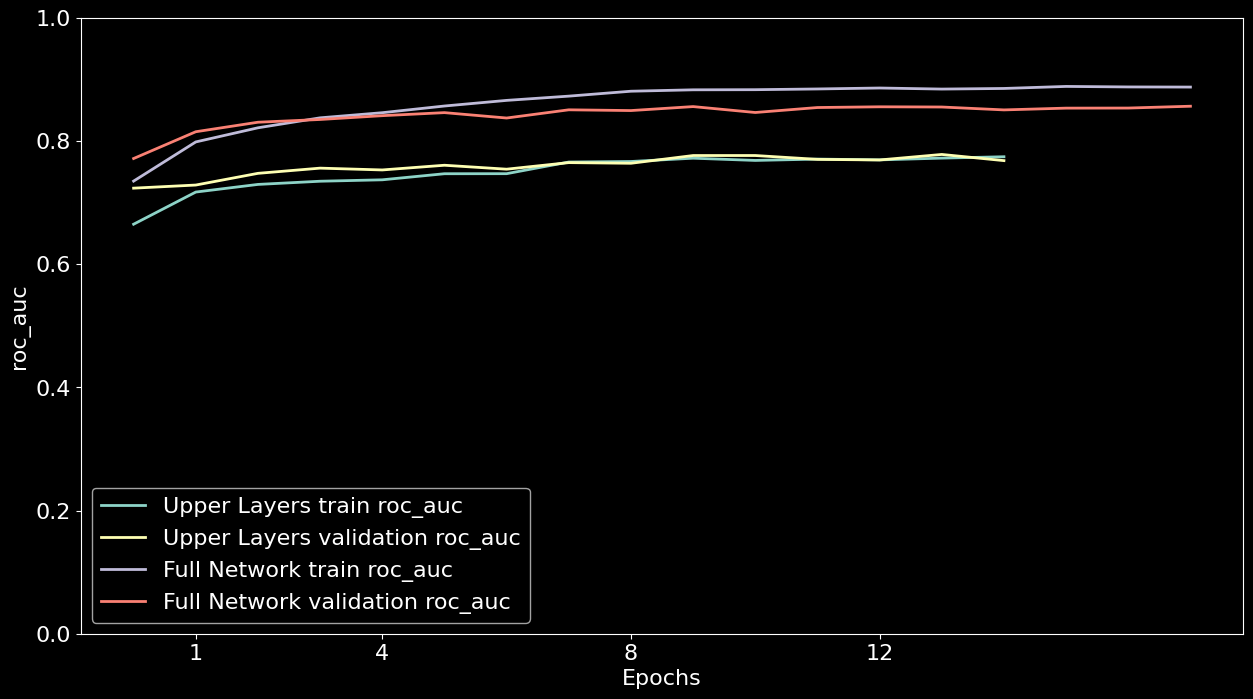

In [ ]:
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='loss'
)
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='pr_auc'
)
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='roc_auc'
)

# **InceptionV3**

We will now try a different pre-trained CNN, namely [InceptionV3](https://arxiv.org/abs/1512.00567) to see if we can get better results.

##**Fine -Tuning**
The way we approached the fine-tuning process was:
1. we firstly added a number of dense layers on top of the pre-trained network
2. we froze the weights of the pre-trained network and trained the complete CNN for 15 epochs
3. we un-froze the weights of the layers of the pre-trained network and trained the complete model until the early_stopping criterion was used to terminate the training process.

In [ ]:
def train_model(
        upper_layers_optimizer,
        full_network_optimizer,
        upper_layers_epochs=15,
        full_network_epochs=85,
        batch_size=512,
        mlp_hidden_layers=[2048,512],
        mlp_hidden_activation='relu',
        mlp_dropout=0.2,
        output_activation='sigmoid',
        callbacks=None,
        verbose=0):

    np.random.seed(1402)
    set_seed(1981)

    base_model = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3),
        pooling='max',
    )

    x = base_model.output
    # Define MLP layers.
    for i, units in enumerate(mlp_hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=mlp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if mlp_dropout > 0:
            x = Dropout(rate=mlp_dropout)(x)


    # Define the output layer.
    output = Dense(
        units=1,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=base_model.input, outputs=output)

    # First train the upper layers for a few epochs
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=upper_layers_optimizer, loss='binary_crossentropy', metrics=METRICS)
    hs_upper_layers = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=upper_layers_epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training upper layers.')
    print('------------------')

    # Now train the whole network with a low learning rate
    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer=full_network_optimizer, loss='binary_crossentropy', metrics=METRICS)

    hs_full_network = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=full_network_epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training full network.')
    print('------------------')

    model.summary() # Print a description of the model.
    return model, hs_upper_layers, hs_full_network


Let us now proceed with the training process. We opted to use [AdamW](https://arxiv.org/abs/1711.05101v3) as optimizer which is a stochastic optimization method that modifies the typical implementation of weight decay in Adam, by decoupling weight decay from the gradient update. As far as the learning rate is concearned, we chose the default regarding the upper layers (0.001) and a value of 0.00001 for the full network. The reasoning behind this is that we do  not wish the model to lose the features it has already learned. Again, we also employ early stopping and a gradual reduction of the learning rate for the reasons we have already mentioned earlier in this notebook.



In [ ]:
# Initialize and train InceptionV3 model with AdamW optimizer and specific hyperparameters
upper_layers_optimizer = AdamW()
full_network_optimizer = AdamW(1e-5)
dns_model, dns_upper_hs, dns_full_network_hs = train_model(
    upper_layers_optimizer=upper_layers_optimizer,
    full_network_optimizer=full_network_optimizer,
    batch_size=512,
    mlp_hidden_layers=[2048, 2048, 1024, 512],
    mlp_hidden_activation='relu',
    mlp_dropout=0.2,
    output_activation='sigmoid',
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/15
978/978 [==============================] - 227s 213ms/step - loss: 0.6788 - tp: 3684.0000 - fp: 2931.0000 - tn: 15679.0000 - fn: 8992.0000 - binary_acc: 0.6189 - precision: 0.5569 - recall: 0.2906 - roc_auc: 0.6277 - pr_auc: 0.5091 - val_loss: 0.6829 - val_tp: 111.0000 - val_fp: 41.0000 - val_tn: 1626.0000 - val_fn: 1419.0000 - val_binary_acc: 0.5433 - val_precision: 0.7303 - val_recall: 0.0725 - val_roc_auc: 0.6620 - val_pr_auc: 0.6248 - lr: 0.0010
Epoch 2/15
978/978 [==============================] - 185s 189ms/step - loss: 0.6438 - tp: 5272.0000 - fp: 4292.0000 - tn: 14318.0000 - fn: 7404.0000 - binary_acc: 0.6262 - precision: 0.5512 - recall: 0.4159 - roc_auc: 0.6488 - pr_auc: 0.5254 - val_loss: 0.6599 - val_tp: 429.0000 - val_fp: 185.0000 - val_tn: 1482.0000 - val_fn: 1101.0000 - val_binary_acc: 0.5977 - val_precision: 0.6987 - val_recall: 0.2804 - val_roc_auc: 0.6854 - val_pr_auc: 0.6376 - lr: 0.0010
Epoc

##**Saving & Loading**
With the training of the full network now complete we decided to save the configuration and the weights of the model on our Google Drive as the training process requires a lot of time and a lot of things can go wrong. (Saved on Yiota's Drive)

In [ ]:
model_json = dns_model.to_json()
with open("/content/drive/MyDrive/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize weights to HDF5
dns_model.save_weights("/content/drive/MyDrive/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/drive/MyDrive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer=AdamW(1e-5), loss='binary_crossentropy', metrics=METRICS)

##**Evaluation**

In [ ]:
eval = loaded_model.evaluate(test_ds)

173/173 [==============================] - 32s 176ms/step - loss: 0.4500 - tp: 2384.0000 - fp: 481.0000 - tn: 4511.0000 - fn: 1343.0000 - binary_acc: 0.7908 - precision: 0.8321 - recall: 0.6397 - roc_auc: 0.8508 - pr_auc: 0.8351


In [ ]:
F1_Inc = 2 * (0.8321 *  0.6397) / (0.8321 +  0.6397)
print("The F1-Score is:",round(F1_Inc,4))

The F1-Score is: 0.7233


##**Learning Curves**

We continue by constructing the learning curves in order to provide some insights about how well the model is learning over time.

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1,4)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(f"{metric}")
    plt.legend()
    plt.show()

By observing the plot that refers to Loss, we notice that there is no overfitting. This conclusion has derrived from the fact that the training and validation curves for both the Upper Layers and the Full Network are not far from one another.

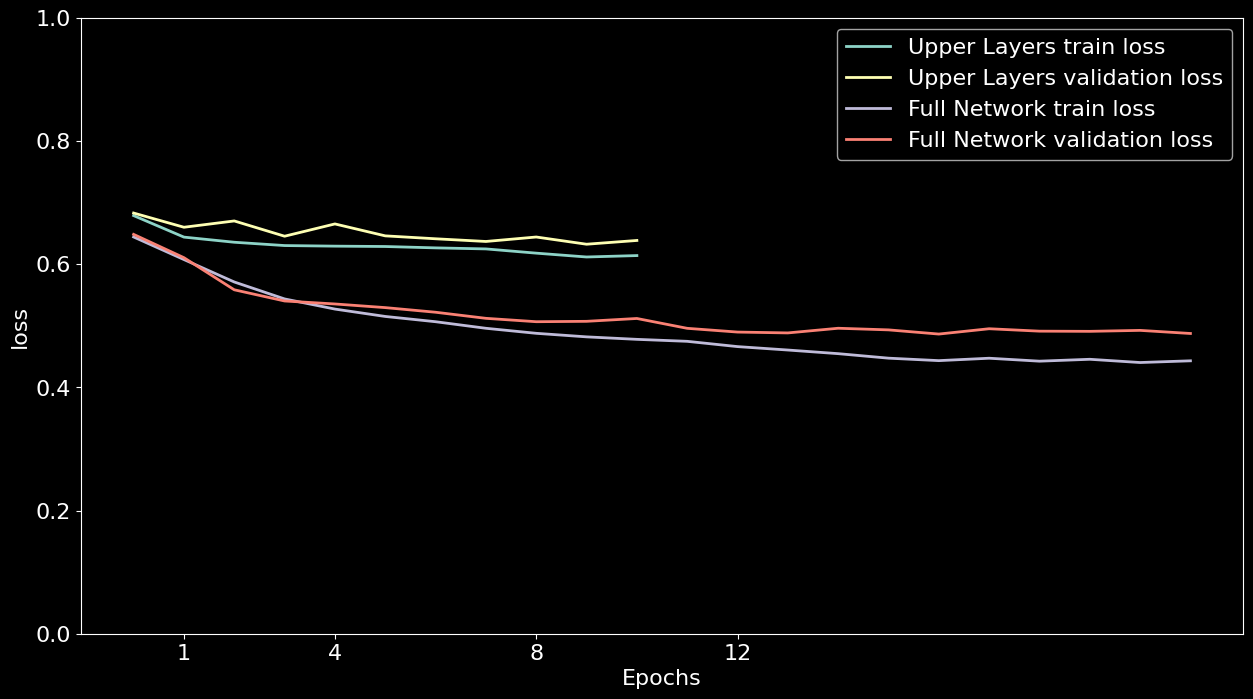

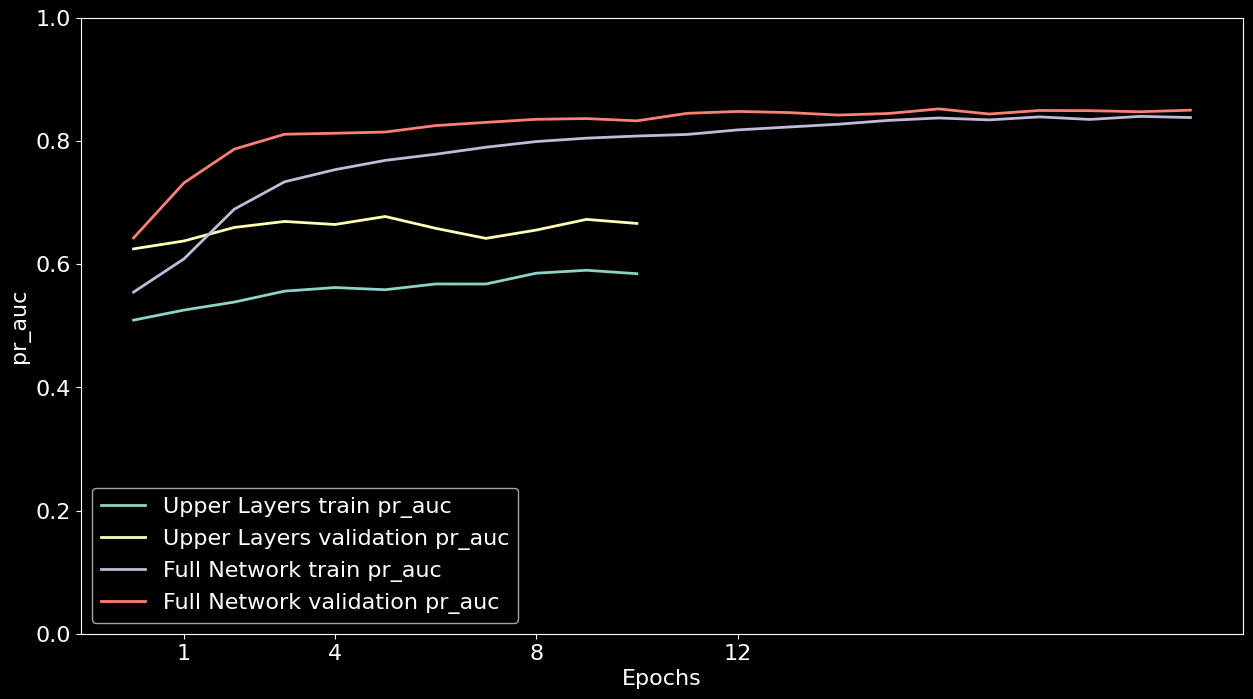

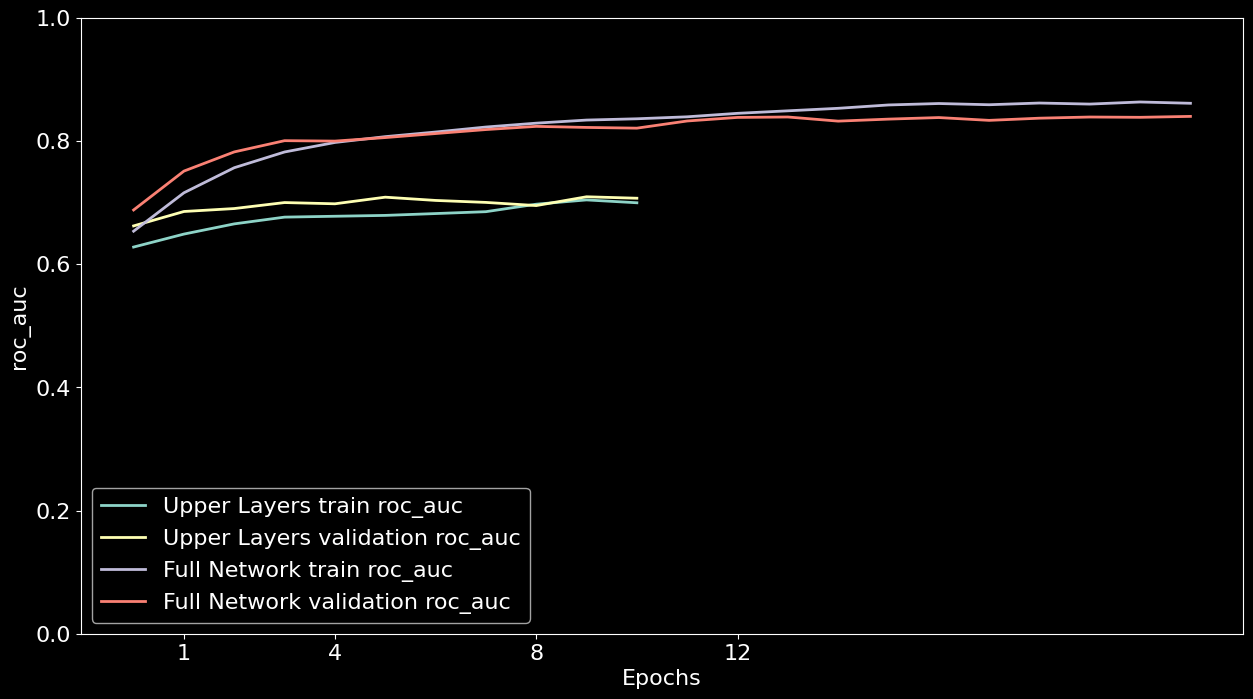

In [ ]:
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='loss'
)
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='pr_auc'
)
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='roc_auc'
)

#**MobileNetV2**
Finally, we will implement another Pre-trained model called [MobileNetV2](https://arxiv.org/abs/1801.04381v4). What makes this model special is the fact that it is really lightweight as it doesn't require much RAM.

##**Fine -Tuning**
We approached the fine-tuning process in similar fashion like before:
1. we firstly added a number of dense layers on top of the pre-trained network
2. we froze the weights of the pre-trained network and trained the complete CNN for 15 epochs
3. we un-froze the weights of the layers of the pre-trained network and trained the complete model until the early_stopping criterion was used to terminate the training process.

In [ ]:
def train_model(
        upper_layers_optimizer,
        full_network_optimizer,
        upper_layers_epochs=15,
        full_network_epochs=85,
        batch_size=512,
        mlp_hidden_layers=[2048,512],
        mlp_hidden_activation='relu',
        mlp_dropout=0.2,
        output_activation='sigmoid',
        callbacks=None,
        verbose=0):

    np.random.seed(1402)
    set_seed(1981)

    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3),
        pooling='max',
    )

    x = base_model.output
    # Define MLP layers.
    for i, units in enumerate(mlp_hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=mlp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if mlp_dropout > 0:
            x = Dropout(rate=mlp_dropout)(x)


    # Define the output layer.
    output = Dense(
        units=1,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=base_model.input, outputs=output)

    # First train the upper layers for a few epochs
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=upper_layers_optimizer, loss='binary_crossentropy', metrics=METRICS)
    hs_upper_layers = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=upper_layers_epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training upper layers.')
    print('------------------')

    # Now train the whole network with a low learning rate
    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer=full_network_optimizer, loss='binary_crossentropy', metrics=METRICS)

    hs_full_network = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=full_network_epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training full network.')
    print('------------------')

    model.summary() # Print a description of the model.
    return model, hs_upper_layers, hs_full_network


Let us now proceed with the training process. Again, we opted to use AdamW as optimizer keeping the same learning rates are before. We also employ early stopping and a gradual reduction of the learning rate.

In [ ]:
# Initialize and train the model with AdamW optimizer and specific hyperparameters
upper_layers_optimizer = AdamW()
full_network_optimizer = AdamW(1e-5)
dns_model, dns_upper_hs, dns_full_network_hs = train_model(
    upper_layers_optimizer=upper_layers_optimizer,
    full_network_optimizer=full_network_optimizer,
    batch_size=512,
    mlp_hidden_layers=[2048, 2048, 1024, 512],
    mlp_hidden_activation='relu',
    mlp_dropout=0.2,
    output_activation='sigmoid',
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/15
978/978 [==============================] - 207s 195ms/step - loss: 0.6576 - tp: 4469.0000 - fp: 3362.0000 - tn: 15248.0000 - fn: 8207.0000 - binary_acc: 0.6302 - precision: 0.5707 - recall: 0.3526 - roc_auc: 0.6450 - pr_auc: 0.5453 - val_loss: 0.6126 - val_tp: 779.0000 - val_fp: 381.0000 - val_tn: 1286.0000 - val_fn: 751.0000 - val_binary_acc: 0.6459 - val_precision: 0.6716 - val_recall: 0.5092 - val_roc_auc: 0.7190 - val_pr_auc: 0.7122 - lr: 0.0010
Epoch 2/15
978/978 [==============================] - 167s 170ms/step - loss: 0.6135 - tp: 5211.0000 - fp: 2925.0000 - tn: 15685.0000 - fn: 7465.0000 - binary_acc: 0.6679 - precision: 0.6405 - recall: 0.4111 - roc_auc: 0.6997 - pr_auc: 0.6209 - val_loss: 0.5926 - val_tp: 751.0000 - val_fp: 265.0000 - val_tn: 1402.0000 - val_fn: 779.0000 - val_binary_acc: 0.6734 - val_precision: 0.7392 - val_recall: 0.4908 - val_roc_auc: 0.7478 - val_pr_auc: 0.7460 - lr: 0.0010
Epoch 3

##**Saving & Loading**
With the training of the full network now complete we decided to save the configuration and the weights of the model on our Google Drive as the training process requires a lot of time and a lot of things can go wrong. (saved on Despoina's Drive)

In [ ]:
model_json = dns_model.to_json()
with open("/content/drive/MyDrive/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize weights to HDF5
dns_model.save_weights("/content/drive/MyDrive/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/drive/MyDrive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer=AdamW(1e-5), loss='binary_crossentropy', metrics=METRICS)

##**Evaluation**

In [ ]:
eval = loaded_model.evaluate(test_ds)

173/173 [==============================] - 41s 230ms/step - loss: 0.4688 - tp: 2353.0000 - fp: 541.0000 - tn: 4451.0000 - fn: 1374.0000 - binary_acc: 0.7804 - precision: 0.8131 - recall: 0.6313 - roc_auc: 0.8395 - pr_auc: 0.8253


In [ ]:
precision,recall=eval[6],eval[7]

In [ ]:
F1_MobNet = 2 * (precision * recall) / (precision + recall)
print("The F1-Score is:",round(F1_MobNet,4))

The F1-Score is: 0.7108


##**Learning Curves**

We continue by constructing the learning curves in order to provide some insights about how well the model is learning over time.

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1,4)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(f"{metric}")
    plt.legend()
    plt.show()

By observing the plot that refers to Loss, we notice that there is no overfitting. This conclusion has derrived from the fact that the training and validation curves for both the Upper Layers and the Full Network are not far from one another.

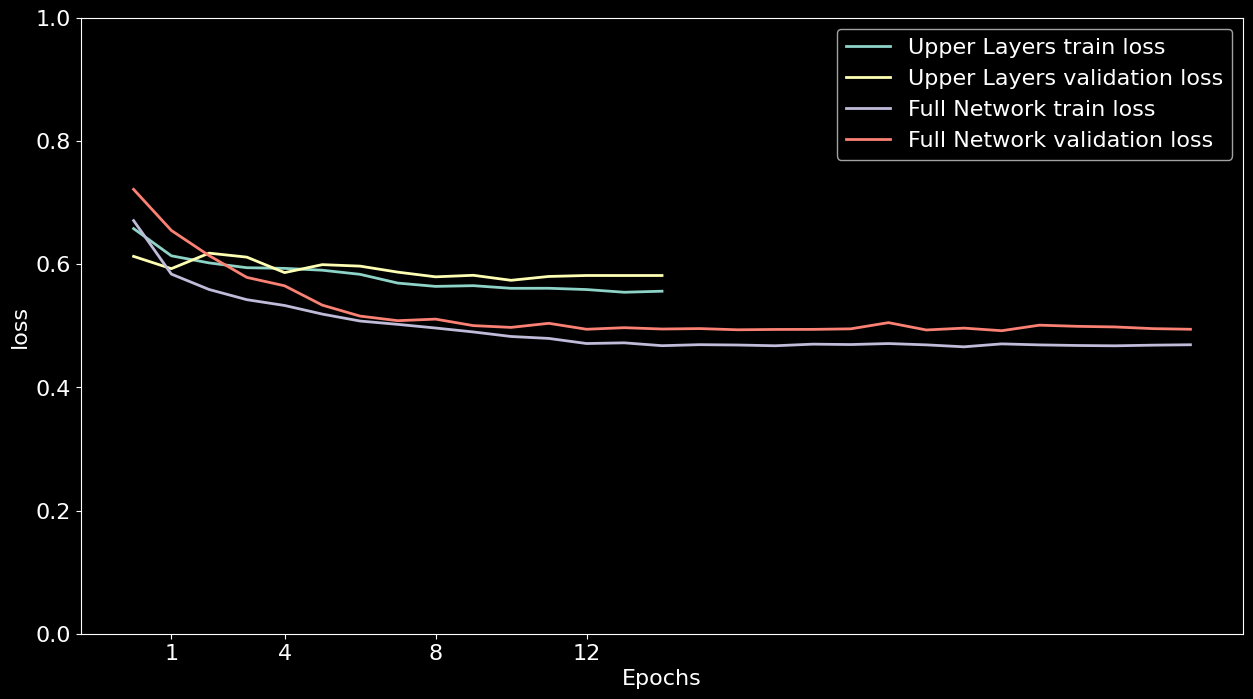

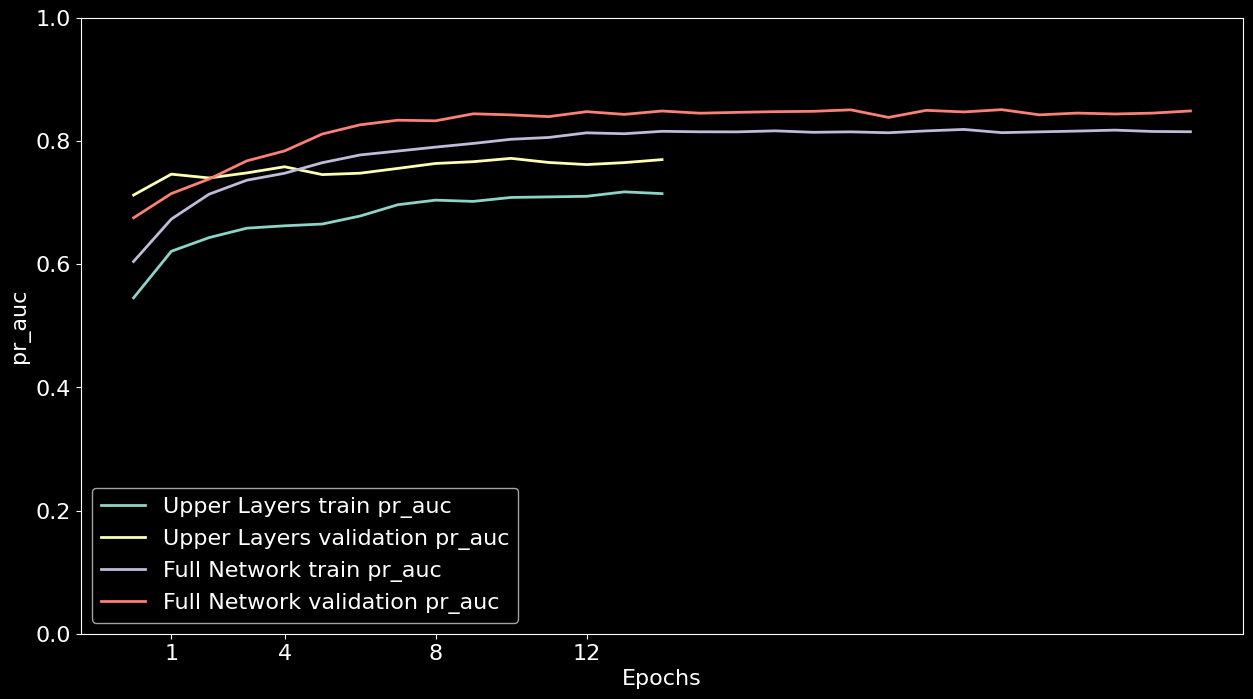

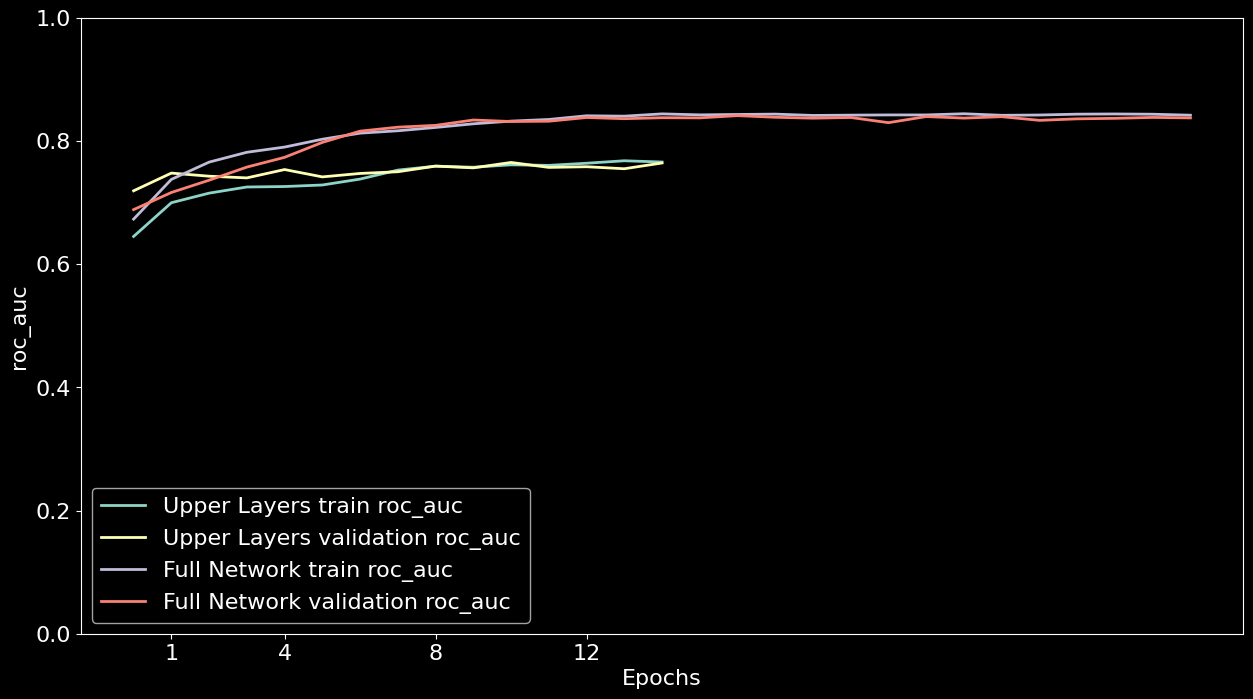

In [ ]:
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='loss'
)
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='pr_auc'
)
plot_history(
    hs={
        'Upper Layers': dns_upper_hs,
        'Full Network': dns_full_network_hs
    },
    epochs=15,
    metric='roc_auc'
)

#**Conclusions**
To conclude we will make a comparison between our CNN, Densenet201, InceptionV3 and MobileNetV2  in order to determine which one performed best. Below we provide some metrics for each model: \

**CNN:** \
 * binary_acc: 0.6470
 * precision: 0.5785
 * recall: 0.4160
 * roc_auc: 0.6746
 * pr_auc: 0.5673
 * F1-Score: 0.484

**Densenet201:** \
* binary_acc: 0.8030
* precision: 0.7948
* recall: 0.6805
* roc_auc: 0.8624
* pr_auc: 0.8362
* F1-Score: 0.7332

**InceptionV3:** \
* binary_acc: 0.7908
* precision: 0.8321
* recall: 0.6397
* roc_auc: 0.8508
* pr_auc: 0.8351
* F1-Score: 0.7233

**MobileNetV2:**
* binary_acc: 0.7804
* precision: 0.8131
* recall: 0.6313
* roc_auc: 0.8395
* pr_auc: 0.8253
* F1-Score: 0.7108


\
**Observations:** \

By looking at the provided metrics we notice that *Densenet201* has the highest binary accuracy, F1-Score and ROC AUC among the four models. It also has a relatively high precision, recall and F1-Score, indicating a good balance between identifying positive cases correctly and minimizing false positives. \

To continue, *InceptionV3* performs best in terms of precision, but it has lower recall and F1-Score compared to Densenet201, indicating that it may miss some positive cases. However, it still achieves high ROC AUC, PR AUC and a relatively high binary accuracy. \

As far as *MobileNetV2* is concerned, we notice that it outperformed Densenet201 in terms of precision. Regarding the other metrics, it achieved a relatively high binary accuracy, recall and F1-Score. Moreover, it managed to reach high ROC AUC and PR AUC.

Finally, the *custom CNN* has the lowest performance across all metrics compared to the other two models. This was expected as the pre-trained models were already trained on a vast dataset.

**...and the best performance medal goes to** (drum roll, please) **: Densenet201** 🥇
  
